# ShallowFBCSPNet with P300 data

## Environment
conda create -n P300_pipeline python=3.11 \
conda activate P300_pipeline

## Packages

pip install \
  "numpy<2" \
  "moabb<1.4" \
  "pyriemann<0.9" \
  braindecode \
  mne \
  scipy \
  pandas \
  scikit-learn\


python -m pip install -U ipykernel\
python -m ipykernel install --user --name P300_pipeline --display-name "Python (P300_pipeline)"


## Dataset

In [7]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)


/opt/anaconda3/envs/P300_pipeline/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bnci-horizon-2020.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  Passes additional parameters to the constructor of the appropriate
/opt/anaconda3/envs/P300_pipeline/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  Passes additional parameters to the constructor of the appropriate
100%|█████████████████████████████████████| 18.5M/18.5M [00:00<00:00, 8.18GB/s]
SHA256 hash of downloaded file: d6b40d723b90bb9a71127be66d7c3f66a13861cacafdb7c45efbcb8fcf9a726e
Use this value as the 'known_hash' argument of

Number of recordings: 30
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [ ]:
# see subjects and their sessions
import pandas as pd
pd.set_option("display.max_columns", None)

dataset_full.description.groupby("subject").size()

subject
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
dtype: int64

In [2]:
from braindecode.datasets import MOABBDataset

subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

In [14]:
# One subject → one or more MNE Raw objects
raw = dataset.datasets[0].raw

print(raw)

# Channel names
print(raw.ch_names)

# Channel types (EEG, stim, etc.)
print(raw.get_channel_types())


<RawArray | 18 x 50184 (196.0 s), ~6.9 MiB, data loaded>
['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4', 'Target stim', 'Flash stim']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim']


In [16]:
import mne
#  Number of channels
print("n_channels:", raw.info["nchan"])

# Sampling frequency
print("sfreq:", raw.info["sfreq"])

# Pick only EEG channels
eeg_picks = mne.pick_types(raw.info, eeg=True, stim=False)
print("EEG channel indices:", eeg_picks)
print("EEG channel names:", [raw.ch_names[i] for i in eeg_picks])


n_channels: 18
sfreq: 256.0
EEG channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
EEG channel names: ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']


In [ ]:
# Get EEG data as numpy array (shape: n_channels x n_samples))
data = raw.get_data(picks="eeg")

print("EEG data shape:", data.shape)


EEG data shape: (16, 50184)


In [18]:
# check events and labels 
events, event_id = mne.events_from_annotations(raw)

print("Event IDs:", event_id)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: [np.str_('NonTarget'), np.str_('Target')]
Event IDs: {np.str_('NonTarget'): 1, np.str_('Target'): 2}
First 10 events:
 [[1544    0    1]
 [1608    0    1]
 [1672    0    2]
 [1736    0    1]
 [1800    0    1]
 [1864    0    1]
 [1928    0    1]
 [1992    0    1]
 [2056    0    2]
 [2120    0    1]]


Using matplotlib as 2D backend.


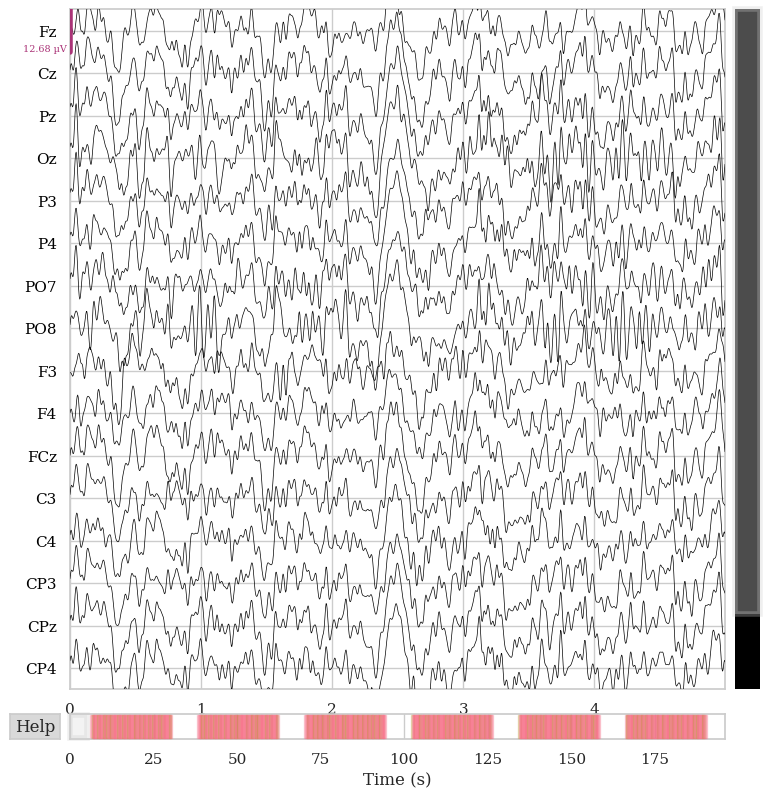

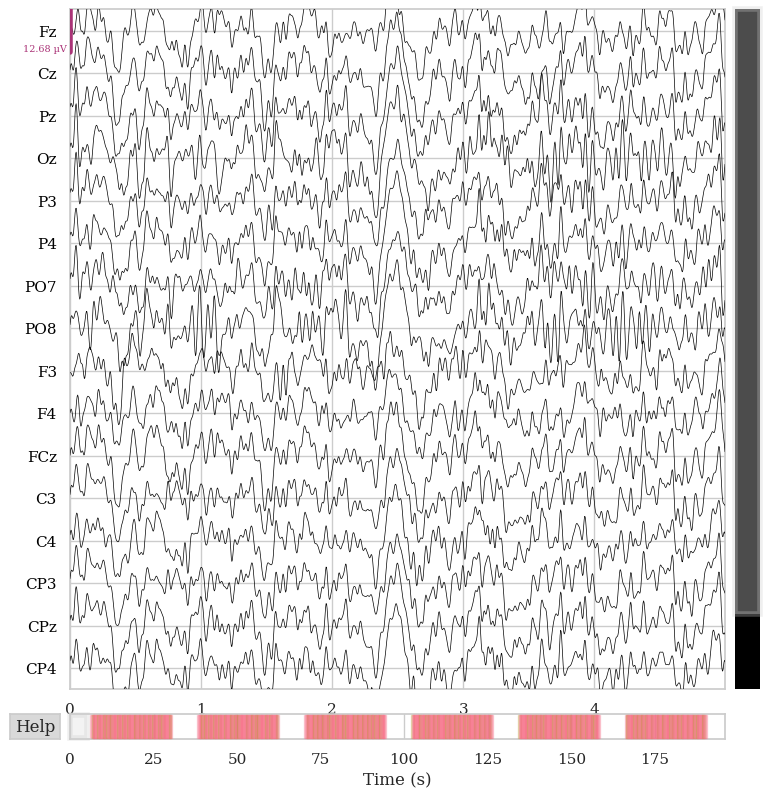

In [19]:
# Plot a few seconds of EEG
raw.plot(n_channels=16, duration=5, scalings="auto")


## Preprocessing

In [ ]:
import numpy as np
from braindecode.preprocessing import (
    Preprocessor,
    preprocess,
)

# bandpass filter that matches dataset 
low_cut_hz = 0.1
high_cut_hz = 20.0
factor = 1e6 # to convert from V to uV
#resample_sfreq = 128  # set to none if you want to keep it at 256 Hz

def to_microvolts(data):
    return data * factor

preprocessors = [
    # keep only EEG channels
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),
    # scale the data
    Preprocessor(to_microvolts),
    # bandpass filter for ERPs
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),
]

# apply the preprocessors to the dataset
preprocess(dataset, preprocessors, n_jobs=-1)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
Filtering raw data in 1 contiguous segment
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
Filtering raw data in 1 contiguous segment
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
Setting up band-pass filter from 0.1 - 20 Hz
- Lower transition 

## Creating trial windows

In [4]:
from braindecode.preprocessing import create_windows_from_events

# read sampling frequency from the data
sfreq = dataset.datasets[0].raw.info["sfreq"]
print("sampling frequency:", sfreq)

# trial window setting for P300
tmin = 0.0
tmax = 0.8

start_offset = int(np.round(tmin * sfreq))
stop_offset = int(np.round(tmax * sfreq))

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=start_offset,
    trial_stop_offset_samples=stop_offset,
    preload=True,
)

print(windows_dataset)
print(windows_dataset.description.head())
print(windows_dataset.description.columns)


sampling frequency: 256.0
Used Annotations descriptions: ['NonTarget', 'Target']
Used Annotations descriptions: ['NonTarget', 'Target']
Used Annotations descriptions: ['NonTarget', 'Target']
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
Index(['subject', 'session', 'run'], dtype='object')


In [6]:
# count number of target and non-target trials
y = np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])

n_nontarget = np.sum(y == 0)
n_target = np.sum(y == 1)

print(f"NonTarget (0): {n_nontarget}")
print(f"Target (1): {n_target}")
print(f"Total windows: {len(y)}")



NonTarget (0): 1440
Target (1): 288
Total windows: 1728


## Splitting the dataset into training and validation sets